# This notebook has the commands for creating a horizontal bar chart for the ADHD proportion data within communities

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
#filtered_data_arms1 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/fluid_ADHDscores_ARMS2_arms1xgb_merged.csv")
#filtered_data_arms2 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/fluid_ADHDscores_ARMS1_arms2xgb_merged.csv")
#filtered_data_arms1 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/list_ADHDscores_ARMS2_arms1xgb_merged.csv")
#filtered_data_arms2= pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/list_ADHDscores_ARMS1_arms2xgb_merged.csv")
data_arms1 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_list_ARMS1_merged.csv")
data_arms2 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_list_ARMS2_merged.csv")
#data_arms1 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_fluid_ARMS1_merged.csv")
#data_arms2 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_fluid_ARMS2_merged.csv")
#data_arms2 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_list_ARMS2_merged.csv")
filtered_data_arms2

,subjectkey,ADHD1,ADHD2,ADHD3,ADHD4,ADHDcomposite,community
0,NDAR_INV00J52GPG,Ctrl,Ctrl,Ctrl,Ctrl,0.364275,4
1,NDAR_INV00NPMHND,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,1
2,NDAR_INV01NAYMZH,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,5
3,NDAR_INV021403LF,ADHD,ADHD,Ctrl,Ctrl,1.444422,6
4,NDAR_INV022ZVCT8,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,1
...,...,...,...,...,...,...,...
3228,NDAR_INVZZ3P1ZFJ,Ctrl,Ctrl,Ctrl,Ctrl,1.137971,2
3229,NDAR_INVZZ6ZJ2KY,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,5
3230,NDAR_INVZZ81LEEV,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,2
3232,NDAR_INVZZZ2ALR6,Ctrl,Ctrl,Ctrl,Ctrl,0.033034,1


In [64]:
#currently keeping all communities, regardless of size, because we are trying to evaluate across the arms with the overfit xgb model

communities_more_than_100_arms1 = data_arms1['community'].value_counts()[data_arms1['community'].value_counts() > 100].index
communities_more_than_100_arms2 = data_arms2['community'].value_counts()[data_arms2['community'].value_counts() > 100].index
filtered_data_arms1 = data_arms1[data_arms1['community'].isin(communities_more_than_100_arms1)]
filtered_data_arms2 = data_arms2[data_arms2['community'].isin(communities_more_than_100_arms2)]

In [65]:
#convert community to a categorical variable to ensure proper ordering on the x-axis
filtered_data_arms1.loc[:, 'community'] = pd.Categorical(filtered_data_arms1['community'])
filtered_data_arms2.loc[:, 'community'] = pd.Categorical(filtered_data_arms2['community'])

In [66]:
#function to determine the grouping of all possible adhd label combinations/conditions

def filter_adhd(df, **conditions):
    query = ' & '.join([f"{k} == '{v}'" for k, v in conditions.items()])
    return df.query(query)

In [67]:
#all the possible adhd label combinations/conditions

conditions_arms1 = [
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'}
]

conditions_arms2 = conditions_arms1  # The conditions are the same for arms2

In [68]:
#determine the counts for the condition groups

groups_arms1 = [filtered_data_arms1] + [filter_adhd(filtered_data_arms1, **cond) for cond in conditions_arms1]
groups_arms2 = [filtered_data_arms2] + [filter_adhd(filtered_data_arms2, **cond) for cond in conditions_arms2]
groups_arms2

[            subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
 0     NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275          4
 1     NDAR_INV00NPMHND  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990          1
 2     NDAR_INV01NAYMZH  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990          5
 3     NDAR_INV021403LF  ADHD  ADHD  Ctrl  Ctrl       1.444422          6
 4     NDAR_INV022ZVCT8  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990          1
 ...                ...   ...   ...   ...   ...            ...        ...
 3228  NDAR_INVZZ3P1ZFJ  Ctrl  Ctrl  Ctrl  Ctrl       1.137971          2
 3229  NDAR_INVZZ6ZJ2KY  Ctrl  Ctrl  Ctrl  Ctrl      -0.189392          5
 3230  NDAR_INVZZ81LEEV  Ctrl  Ctrl  Ctrl  Ctrl      -0.189392          2
 3232  NDAR_INVZZZ2ALR6  Ctrl  Ctrl  Ctrl  Ctrl       0.033034          1
 3233  NDAR_INVZZZNB0XC  ADHD  ADHD  ADHD  Ctrl       0.899638          3
 
 [3176 rows x 7 columns],
             subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
 0     NDA

In [69]:
#better display of the counts

for group in groups_arms1:
    if not group.empty:
        print(group.head(1))
        print(len(group))

#outputs are in order: total, no adhd, adhd1, adhd2, adhd3, adhd4

         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV003RTV85  Ctrl  Ctrl  Ctrl  Ctrl      -0.638587          7
3146
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV003RTV85  Ctrl  Ctrl  Ctrl  Ctrl      -0.638587          7
2931
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
332  NDAR_INV2DTHE81G  ADHD  Ctrl  Ctrl  Ctrl        2.79549          3
14
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
25  NDAR_INV05LGG3GZ  ADHD  ADHD  Ctrl  Ctrl       1.067142          7
83
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
107  NDAR_INV0UPRUMA1  ADHD  ADHD  ADHD  Ctrl       0.098208          1
42
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
6  NDAR_INV00U4FTRU  ADHD  ADHD  ADHD  ADHD       2.920183          1
76


In [70]:
for group in groups_arms2:
    if not group.empty:
        print(group.head(1))
        print(len(group))

         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275          4
3176
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275          4
2928
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
161  NDAR_INV20CNYBBC  ADHD  Ctrl  Ctrl  Ctrl       1.741991          6
7
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
3  NDAR_INV021403LF  ADHD  ADHD  Ctrl  Ctrl       1.444422          6
90
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
48  NDAR_INV0JAG7BGC  ADHD  ADHD  ADHD  Ctrl       1.936428          5
55
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite  community
73  NDAR_INV0UMM15GY  ADHD  ADHD  ADHD  ADHD       3.435609          2
96


In [71]:
#functions to summarize the label counts into one dataframe

def summarize_by_label(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'ADHD'].assign(ADHD=label)

def summarize_by_label_ctrl(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'Ctrl'].assign(ADHD='Ctrl')

In [72]:
summary_data_arms1_ctrl_adhd1 = summarize_by_label_ctrl(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD1 = summarize_by_label(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD2 = summarize_by_label(filtered_data_arms1, 'ADHD2')
summary_data_arms1_ADHD3 = summarize_by_label(filtered_data_arms1, 'ADHD3')
summary_data_arms1_ADHD4 = summarize_by_label(filtered_data_arms1, 'ADHD4')

In [73]:
summary_data_arms2_ctrl_adhd1 = summarize_by_label_ctrl(filtered_data_arms2, 'ADHD1')
summary_data_arms2_ADHD1 = summarize_by_label(filtered_data_arms2, 'ADHD1')
summary_data_arms2_ADHD2 = summarize_by_label(filtered_data_arms2, 'ADHD2')
summary_data_arms2_ADHD3 = summarize_by_label(filtered_data_arms2, 'ADHD3')
summary_data_arms2_ADHD4 = summarize_by_label(filtered_data_arms2, 'ADHD4')

In [74]:
#combine the summaries together

summary_data_arms1_combined = pd.concat([summary_data_arms1_ctrl_adhd1, summary_data_arms1_ADHD1, summary_data_arms1_ADHD2, summary_data_arms1_ADHD3, summary_data_arms1_ADHD4])
summary_data_arms2_combined = pd.concat([summary_data_arms2_ctrl_adhd1, summary_data_arms2_ADHD1, summary_data_arms2_ADHD2, summary_data_arms2_ADHD3, summary_data_arms2_ADHD4])
summary_data_arms2_combined

,community,ADHD1,count,ADHD,ADHD2,ADHD3,ADHD4
1,1,Ctrl,763,Ctrl,NaN,NaN,NaN
3,2,Ctrl,492,Ctrl,NaN,NaN,NaN
5,3,Ctrl,428,Ctrl,NaN,NaN,NaN
7,4,Ctrl,481,Ctrl,NaN,NaN,NaN
9,5,Ctrl,302,Ctrl,NaN,NaN,NaN
11,6,Ctrl,350,Ctrl,NaN,NaN,NaN
13,7,Ctrl,112,Ctrl,NaN,NaN,NaN
0,1,ADHD,55,ADHD1,NaN,NaN,NaN
2,2,ADHD,46,ADHD1,NaN,NaN,NaN
4,3,ADHD,34,ADHD1,NaN,NaN,NaN


In [75]:
#function to aggregate the new summary data

def aggregate_summary_data(summary_data):
    return summary_data.groupby(['community', 'ADHD'],observed=False).agg(count=('count', 'sum')).reset_index()

In [76]:
agg_data_arms1_test = aggregate_summary_data(summary_data_arms1_combined)
agg_data_arms2_test = aggregate_summary_data(summary_data_arms2_combined)
agg_data_arms2_test

,community,ADHD,count
0,1,ADHD1,55
1,1,ADHD2,55
2,1,ADHD3,28
3,1,ADHD4,18
4,1,Ctrl,763
5,2,ADHD1,46
6,2,ADHD2,44
7,2,ADHD3,26
8,2,ADHD4,16
9,2,Ctrl,492


In [77]:
#calculate the relevant proportions and add it as a new column

agg_data_arms1_test['proportion'] = agg_data_arms1_test.groupby('community', observed=False)['count'].transform(lambda x: x / x.sum())
agg_data_arms2_test['proportion'] = agg_data_arms2_test.groupby('community', observed=False)['count'].transform(lambda x: x / x.sum())
agg_data_arms2_test

,community,ADHD,count,proportion
0,1,ADHD1,55,0.059848
1,1,ADHD2,55,0.059848
2,1,ADHD3,28,0.030468
3,1,ADHD4,18,0.019587
4,1,Ctrl,763,0.830250
5,2,ADHD1,46,0.073718
6,2,ADHD2,44,0.070513
7,2,ADHD3,26,0.041667
8,2,ADHD4,16,0.025641
9,2,Ctrl,492,0.788462


In [80]:
#pivot the data to prepare it for visualization

df_pivot = agg_data_arms1_test.pivot(index='community', columns='ADHD', values='proportion')
df_pivot = df_pivot.sort_index()
df_pivot

ADHD,ADHD1,ADHD2,ADHD3,ADHD4,Ctrl
community,,,,,
1,0.056259,0.056259,0.033755,0.022504,0.831224
2,0.034237,0.032810,0.017118,0.007133,0.908702
3,0.044643,0.040179,0.022321,0.011161,0.881696
4,0.106195,0.095575,0.061947,0.047788,0.688496
5,0.047753,0.047753,0.022472,0.011236,0.870787
6,0.076159,0.066225,0.029801,0.019868,0.807947
7,0.088889,0.080000,0.057778,0.044444,0.728889
8,0.041667,0.041667,0.041667,0.016667,0.858333
9,0.053097,0.053097,0.017699,0.008850,0.867257


# Create Plot. Make sure figure is named properly

<Figure size 1200x1000 with 0 Axes>

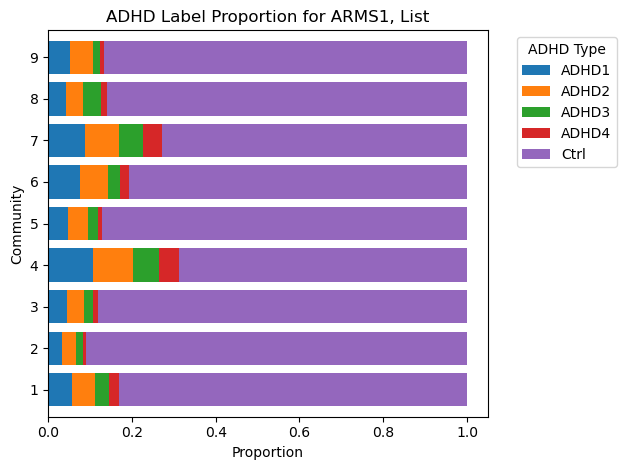

In [81]:
#plot the horizontal bar chart of the adhd label proportion data

#create the horizontal stacked bar chart
plt.figure(figsize=(12, 10))
ax = df_pivot.plot(kind='barh', stacked=True, width=0.8)

#customize the plot
plt.title('ADHD Label Proportion for ARMS1, List')
plt.xlabel('Proportion')
plt.ylabel('Community')

#remove the legend from its current position
plt.legend().remove()

#add a legend to the right of the plot
plt.legend(title='ADHD Type', bbox_to_anchor=(1.05, 1), loc='upper left')

#add percentage labels on the bars
#for c in ax.containers:
#    ax.bar_label(c, fmt='%.2f%%', label_type='center')

#adjust layout and display the plot
plt.tight_layout()
plt.savefig('./list_adhd_proportions_arms1data_remake.png', dpi=300, bbox_inches='tight')
plt.show()